# PDE Modelling 

## Objectives 
* Make a model that describes cell growth and signalling at the scale of colonies 

## Model considerations 
* Species
    1. Cell density 
    1. Nutrient density 
    1. Environmental AHL (considered equal to intracellular concentration)
    1. Synthase / GFP
    1. Repressor or degradase
* Reactions 
    1. cell growth and diffusion 
        * Cells diffuse very slowly
        * nutrient-dependent growth (from Liu et al 2011, Science) 
        $$  $$ 
    1. Transcriptional activation
        * Basal protein expression -> scaled by repression? probably
        * Activation by internal AHL 
        * Use Hill function $$H(A(t), n, k) = \frac{A(t)^2}{k^n + A(t)^n}$$
        * Activation term, with basal expression and expression rate x
        $$X(A(t), n, k, b, x) = x\frac{A(t)^2}{k^n + A(t)^n} + b$$
    1. Transcriptional repression
        * Assume activation is AND-like, meaning that repression trumps activation
        * Use 'repression' Hill function $$H_n(R(t), n, k) = \frac{k^n}{k^n + R(t)^n}$$
        * Rather than considering protein concentrations within cells, calculate protein concentrations as produced by the bulk of cells. Expression is therefore proportional to cell density.
    1. Dilution and degradation 
        * Assume that GFP/Synthase proteins are degradation tagged
        * Degradase is not tagged, so does not have a degradation term
    1. Diffusion 
        * Here, you're going to use convoultion of the diffusion kernel
        * Diffusion in/out of cell is considered faster than spatial diffusion at these scales
    1. 

In [298]:
# imports
from __future__ import division
from __future__ import print_function
import numpy as np
import scipy.integrate as itg 
import scipy.signal as sig
import scipy.ndimage as ndi
import matplotlib.pyplot as plt 
import matplotlib.animation as anm

#%matplotlib inline

## 2D Discrete Laplacian

In continuous form : 
$$ U_t = \triangle U - \lambda U $$

In discrete form, for point $i$ : 
$$ \Delta U_i = \sum_{1 = w(i,j)}\omega(i,j)(U_i - U_j) - \lambda U_i $$

Use discrete laplacian approximation w/o diagonals for grid spacing, so that we can have zero-flux  boundary conditions. 

$$ L = 
 \begin{pmatrix}
  0 & 1 & 0 \\
  1 & -4 & 1 \\
  0 & 1 & 0 
 \end{pmatrix} $$

I use a convolution function to calculate the diffusion terms. 

In [313]:
# Cell model w/ signalling 

# Dimensions
tmax = 20*60
time = np.int(tmax/10)
n =20
n_h = 11
n_w = 21

od0 = 0.5

def disk(A, center, radius):
    h, w = A.shape
    ind_mat = np.zeros((h, w, 2))
    cx, cy = center
    for i in range(h):
        ind_mat[i,:,0] = np.power(np.arange(w) - cx, 2)
    
    for i in range(w):
        ind_mat[:,i,1] = np.power(np.arange(h) - cy, 2)
    
    outmat = (ind_mat[:,:,0] + ind_mat[:,:,1]) < radius**2
    return outmat

species = 4 # Cells, nutrients, AHL, synthase, degradase or laci
quarter="2_aleaky"
sender_cells = np.zeros((n_h, n_w))
sender_cells[1, 1:-1:1] = od0

rec_cells = np.zeros((n_h, n_w))
rec_cells[3, 5] = od0

rdc_cells = np.zeros((n_h, n_w))
rdc_cells[3, 7] = od0

# Make empty array
A = np.zeros((species, n_h, n_w))

# Set initial conditions
# Cells. Spotted along a line through the middle of the arena
A[0,:,:] += sender_cells + rec_cells + rdc_cells

# Blur to make smooth colonies. This is basically cosmetic
#A[0,:,:] = ndi.filters.gaussian_filter(A[0,:,:], 1)
# Nutrients. All at 100
A[1,:,:] = 100*np.ones((n_h, n_w))
# External AHL. Start with a vertical line at the right of high concentration
A[2,:,:] = np.zeros((n_h, n_w))
#A[2,:,-2] = 2.5e6
# GFP / Synthase. All 0 initially
A[3,:,:] = np.zeros((n_h, n_w))
# degradase or repressor. All 0 initially
#A[4,:,:] = np.zeros((n_h, n_w))

# Laplace kernel
diag = 0.5
neig = 1.0
cent = -6.0
W = np.array([[diag, neig, diag],[neig, cent, neig],[diag, neig, diag]])

# units : L = mm, T = minutes, concentration in nM = moles / mm^3
# Da = 6 - 1.2 E-2
# Params :    dx,    Dc,    rc, Kn,   Dn,   kn,  Da,  xa,  xs,  ha,  ka, 
p0 = np.array([4.5,   0, 6e-3,  75,  1e-2,  2, 1e-2, 1e2, 2e-1, 4, 1e2,    
          # kleak,  xd,   pa,    da,   w, leak, dG, periodic, zb
               1e2, 2e-2, 0.015, 2e1, 10, 1e-4, 1e-4, False,  False])

# Change parameter values above. The function definitions inherit the parameter values defined here.
dx, Dc,  rc,    Kn,  Dn,   kn, Da, xa, xs, ha, ka, dleak, xd, pa, da, w, leak, dG, periodic, zb = p0
              
plt.figure()


# In order to use the ODE solver, the array must be flattened to a vector. 
# These functions change the vectors used by the ODE solver into arrays that are
# used by the convolution function
def y_to_mats(y, n=n, species=species):
    if species == 1:
        return y.reshape((n_h, n_w))
    if species > 1:
        return list(y.reshape((species, n_h, n_w)))
    return 1

def mats_to_y(ymats, n=n, species=species):
    y = np.concatenate(ymats).reshape(n_h*n_w*species)
    return y

# Add two rows and columns to a matrix in order to apply boundary conditions. 
# The boundary conditions are no-flux walls, and this is done by setting the boundary
# cells equal to their neighbors. 
def pad(mat):
    zmat = np.zeros((n_h+2, n_w+2))
    if periodic:
        b0, b1 = -1, 0
    else:
        b0, b1 = 0, -1
        
    zmat[1:n_h+1,1:n_w+1] = mat
    if zb:
        return zmat
    
    for i in [0, -1]:
        for j in [0, -1]:
            zmat[i,j] = mat[i,j]
    
    zmat[1:n_h+1,0] = mat[:,b0]
    zmat[1:n_h+1,-1] = mat[:,b1]
    zmat[0,1:n_w+1] = mat[b0,:]
    zmat[-1,1:n_w+1] = mat[b1,:]
    return zmat

def calc_diffusion(mat, W):
    return unpad(sig.convolve(pad(mat), W, 'same'))

# Remove boundary 
def unpad(padmat, n=n, species=species):
    return padmat[1:(n_h+1), 1:(n_w+1)]

def hill(a, n, k):
    return (a**n)/(k**n + a**n)

def hillN(a, n, k):
    return (k**n)/(k**n + a**n)

# ODE definition
def f(y, t):
    # Calculate diffusion terms
    ymats = y_to_mats(y, n, species)
    
    diff_terms = [calc_diffusion(m, W) for m in ymats[1:3]]
    
    # Growth term
    nut_avail = (np.power(ymats[1],2))/(np.power(ymats[1],2) + np.power(Kn,2))
    
    # Calculate derivative values
    #p_t = calc_p_t(ymats, diff_terms, nut_avail)
    #n_t = calc_n_t(ymats, diff_terms, nut_avail)
    #a_t = calc_a_t(ymats, diff_terms, nut_avail)
    #g_t = calc_g_t(ymats, diff_terms, nut_avail)
    
    p_t = rc * nut_avail * ymats[0]
    n_t = (dx*10)*Dn*diff_terms[0] - kn * nut_avail * ymats[0]
    a_t = (dx*10)*Da*diff_terms[1] + xa * (ymats[3]+leak*10)*sender_cells - da*ymats[2]*rdc_cells*ymats[0] - pa * ymats[2]
    g_t = xs * ymats[0] * (hill(ymats[2], ha, ka) + leak) * nut_avail * (rdc_cells + rec_cells) + ymats[0]*xs*sender_cells* nut_avail # - dG*ymats[3]# * ((np.arctan(w*(ymats[0]-0.05))+np.pi)/np.pi)
    #d_t = xd * ymats[0] * dleak * nut_avail * rdc_cells - dG*ymats[4]# * ((np.arctan(w*(ymats[0]-0.05))+np.pi)/np.pi)
    
    dy = [p_t, n_t, a_t, g_t]#, d_t]
    return mats_to_y(dy, n, species)

t = np.linspace(0,tmax,time)

out = itg.odeint(f, mats_to_y(A, n, species), t)

In [314]:
out.shape

(120, 924)

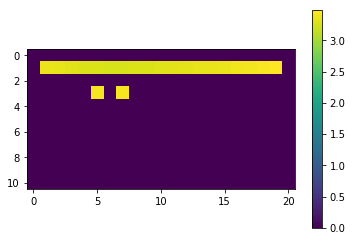

In [315]:
# Take a look at one frame
o_reshaped = np.reshape(out, (time,species,n_h,n_w))

plt.close('all')
img = plt.imshow(o_reshaped[-1,0,:,:], interpolation='none')
plt.colorbar(mappable=img)
plt.show()

In [316]:
# Print out the animated GIF

fig, axs = plt.subplots(nrows=1, ncols=species, figsize=(20,5))

vmaxs, vmins = [[fun(o_reshaped[2:,i,:,:]) for i in range(species)] for fun in [np.max, np.min]]
#vmaxs = [4, 100, 2.5e6, 10, 10]
handles = []
titles = ['Cell density', 'Nutrient', 'AHL', 'GFP']#, 'AiiA']
for j in range(species):
    img = np.empty((n_h,n_w))
    han = axs[j].imshow(img, vmin=vmins[j], vmax=vmaxs[j], interpolation='none', cmap='plasma')
    handles.append(han)
    #fig.colorbar(han, ax=axs[j])
    axs[j].set_title(titles[j])

Writer = anm.writers['imagemagick']
writer = Writer(fps=20, metadata=dict(artist='Me'), bitrate=1800)

cbar_flag = True
# Change filename here
with writer.saving(fig, "joy_exp_q{}_long.gif".format(quarter), 150):
    for i in range(0,time,50):
        for j in range(species):
            handles[j].set_array(o_reshaped[i,j,:,:])
        writer.grab_frame()

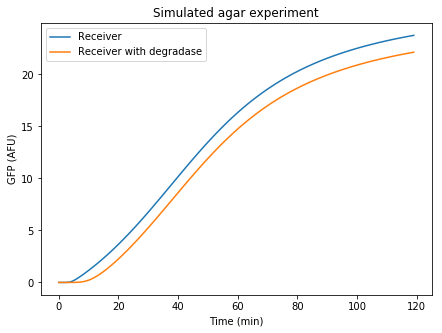

In [317]:
plt.close('all')
plt.figure(figsize=(7,5))
gfp_vec = np.array([o_reshaped[ti,3,:,:]*(rec_cells) for ti in np.arange(time)])
plt.plot(gfp_vec.sum(axis=-1).sum(axis=-1))
gfp_vec = np.array([o_reshaped[ti,3,:,:]*(rdc_cells) for ti in np.arange(time)])
plt.plot(gfp_vec.sum(axis=-1).sum(axis=-1))
plt.ylabel('GFP (AFU)')
plt.xlabel('Time (min)')
plt.title('Simulated agar experiment')
plt.legend(["Receiver", "Receiver with degradase"])
plt.savefig('gifs/joy_exp_gfp_profile_q{}.png'.format(quarter))
plt.show()